# DiaSource counts per CCD, Visit and Night

In this notebook we do some exploratory analysis to see if there are patterns in the DiaSources per ccd, visit and night. We used the data in the 2016 HiTs DECAM rerun in `/project/mrawls/hits2015/rerun/cw_processed5` described in TODO.   The templates are from 2014 HiTs rerun in `/project/mrawls/hits2014/ingested/rerun/processed2`.
    
    
DiaSources can be counted a few different ways:
* All DiaSource Rows
* All DiaSource Rows with no pixel or measurement flags


We assume almost every diaSource is a false positive and therefore DiaSource count is a metric for image subtraction performace. Better perfomance corresponds to lower counts. 
  

## 1) Load and Transform Data
    

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
import lsst.geom
afwDisplay.setDefaultBackend('matplotlib')
import matplotlib.ticker as plticker
import lsst.afw.cameraGeom.testUtils as testUtils
import lsst.afw.cameraGeom as cameraGeom
from lsst.obs.decam import DecamMapper as mapper

In [2]:
# Most Recent Hits2015 rerun with default tasks and configs
REPO = '/project/mrawls/hits2015/rerun/cw_processed5'

# Connect to the PPDB
connection = sqlite3.connect(f'{REPO}/association.db')
# Make a butler
butler = dafPersist.Butler(REPO)

In [3]:
# get columns
columns = pd.read_sql_query('select * from DiaSource limit 1', connection).columns

# get diaSources (ALL)
ds = pd.read_sql_query('select ccdVisitId, ra, decl, psFlux, psFluxErr, midPointTai, x, y, ixxPSF, iyyPSF, ixyPSF, flags from DiaSource', connection)

In [4]:
# create some derived columns
ds['ccd'] = ds.ccdVisitId.apply(lambda x: str(x)[-2:])
ds['visit'] = ds.ccdVisitId.apply(lambda x: str(x)[:-2])

SIGMA2FWHM = 2*np.sqrt(2*np.log(2))
PIXEL_SCALE = 0.2637
traceRadius = np.sqrt(0.5) * np.sqrt(ds.ixxPSF + ds.iyyPSF)
ds['seeing'] = SIGMA2FWHM * traceRadius

In [5]:
# get Focal Plane Coordinates (is there a faster way to do this?)
camera = mapper(root=REPO).camera

def ccd2focalPlane(x, y, ccd):
    cc = int(ccd)
    det = camera[cc]
    point = det.transform(lsst.geom.Point2D(x, y), cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
    return point[0], point[1]

vecCcd2FP =  np.vectorize(ccd2focalPlane)
focal_plane = vecCcd2FP(ds['x'].values.astype(float), ds['y'].values.astype(float), ds['ccd'].values.astype(int))
ds['xFP'] = focal_plane[0]
ds['yFP'] = focal_plane[1]

In [6]:
# get average seeing stored with the calexps
visits = np.unique(ds['visit'])
radius = []
CCD = 35 # Select one ccd from center as representative of seeing.

for visit in visits:
    miniCalexp = butler.get('calexp_sub', visit = int(visit), ccd = 35,
                     bbox=lsst.geom.Box2I())
    radius.append(miniCalexp.getPsf().computeShape(lsst.geom.Point2D(1000, 2000)).getDeterminantRadius())        

In [7]:
bbox = butler.get('calexp_bbox', visit = int(visit), ccd = 35)
APPROX_CCD_AREA = 0.2637*0.2637*bbox.getArea()/3600/3600
APPROX_N_CCD = 59.5
APPROX_VISIT_AREA = APPROX_CCD_AREA * APPROX_N_CCD

In [8]:
fwhm = pd.DataFrame()
fwhm['visit'] = visits
fwhm['sigmaPix'] = radius

In [9]:
# Get flags
from lsst.ap.association import UnpackPpdbFlags, MapDiaSourceConfig
config = MapDiaSourceConfig()
unpacker = UnpackPpdbFlags(config.flagMap, 'DiaSource')
flag_values = unpacker.unpack(ds['flags'], 'flags')
flag_names = list(flag_values.dtype.names)
flagDF = pd.DataFrame(flag_values)
flagDF
idx = flagDF[flag_names].sum(axis = 1) == 0 

/software/lsstsw/stack_20190330/stack/miniconda3-4.5.12-1172c30/Linux64/ap_association/17.0.1-6-ga2de75c+7/python/lsst/ap/association/mapApData.py:388: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  table_list = list(yaml.load_all(yaml_stream))


In [10]:
def plot2axes(x1, y1, x2, y2, xlabel, ylabel1, ylabel2):
    fig, ax1 = plt.subplots(figsize=(16,6))
    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1, color=color)
    ax1.plot(x1, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(ylabel2, color=color)  # we already handled the x-label with ax1
    ax2.plot(x2, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    for label in ax1.get_xticklabels():
        label.set_ha("right")
        label.set_rotation(90)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

# 2)  DiaSources per visit

A few different ways to look at false positives as a function of visits. Most of the variance in diaSources can be explained by the seeing. If the visit PSF is smaller than the template PSF, the template PSF is deconvolved, in which any inaccuracy in the PSF model is amplified. This causes the clear relationship below where false positives improve as the PSF size increases:

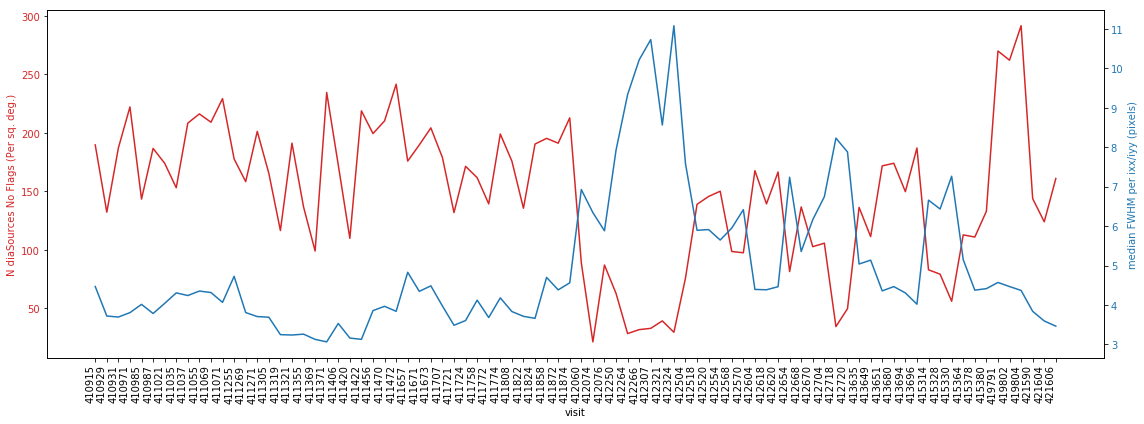

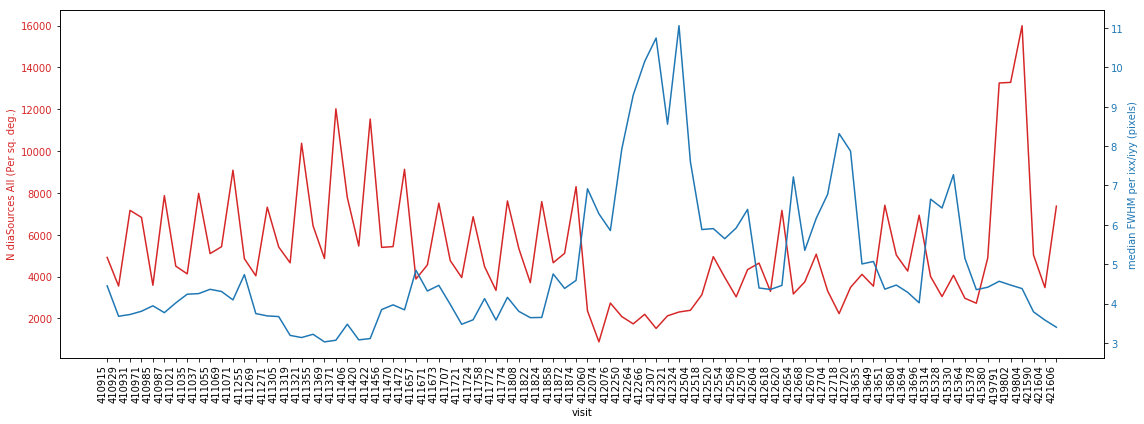

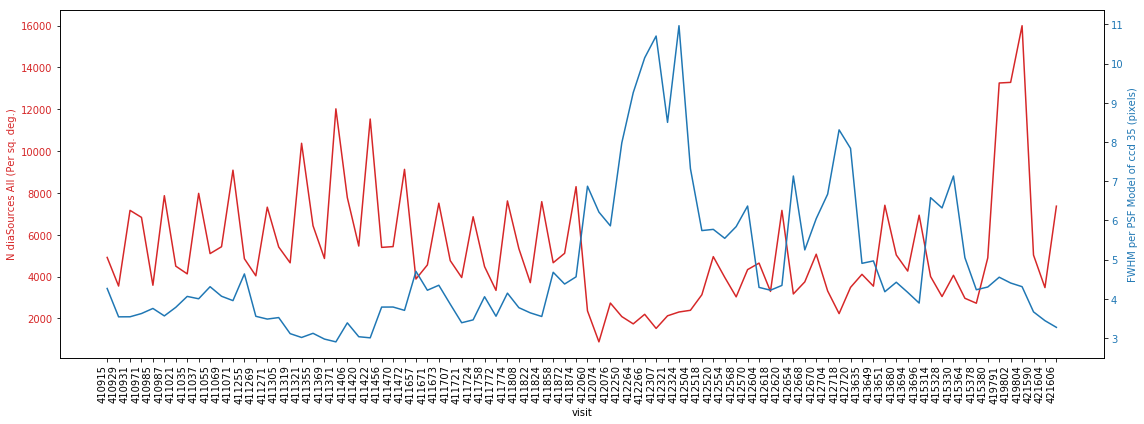

In [11]:
vgrp = ds.groupby('visit')
vgrpClean = ds[idx].groupby('visit')
seeingMerged = pd.merge(vgrp.mean(), fwhm, left_index=True, right_on='visit')

plot2axes(vgrpClean.visit.first().values, vgrpClean.ccd.count().values/APPROX_VISIT_AREA,
          vgrpClean.visit.first().values, vgrpClean.seeing.median().values,
          'visit','N diaSources No Flags (Per sq. deg.)', 'median FWHM per ixx/iyy (pixels)')

plot2axes(vgrp.visit.first().values, vgrp.ccd.count().values/APPROX_VISIT_AREA,
          vgrp.visit.first().values, vgrp.seeing.median().values,
          'visit','N diaSources All (Per sq. deg.)', 'median FWHM per ixx/iyy (pixels)')

plot2axes(vgrp.visit.first().values, vgrp.ccd.count().values/APPROX_VISIT_AREA,
          seeingMerged['visit'], seeingMerged['sigmaPix']*2.355,
          'visit','N diaSources All (Per sq. deg.)', 'FWHM per PSF Model of ccd 35 (pixels)')


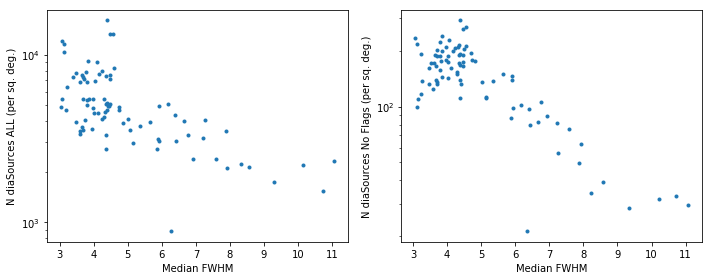

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(vgrp.seeing.median().values, vgrp.ccd.count().values/APPROX_VISIT_AREA, '.')
plt.yscale('log')
plt.ylabel('N diaSources ALL (per sq. deg.)')
plt.xlabel('Median FWHM')
plt.subplot(122)
plt.plot(vgrpClean.seeing.median().values, vgrpClean.ccd.count().values/APPROX_VISIT_AREA, '.')
plt.yscale('log')
plt.ylabel('N diaSources No Flags (per sq. deg.)')
plt.xlabel('Median FWHM')
plt.tight_layout()

# DiaSources per CCD

![Decam CCD Layout](http://www.ctio.noao.edu/noao/sites/default/files/DECam/DECamOrientation.png)


In [13]:
vgrp = ds.groupby('ccd')
vgrpClean = ds[idx].groupby('ccd')
NVisits = len(np.unique(ds['visit'].values))


In [14]:
# Get corners of the ccds. You can prob do this with camera geom too. 
cornerList = []
v = ds['visit'][0]
for ccd in range(1, 63):
    try:
        bbox = butler.get('calexp_bbox', visit=int(v), ccd=ccd)
    except:
        print(ccd)
        continue
    cornerList.append( [int(v), ccd] + [val for pair in bbox.getCorners() for val in ccd2focalPlane(pair[0], pair[1], ccd)])


corners = pd.DataFrame(cornerList)
cornerList
corners['width'] = corners[6] - corners[8]
corners['height'] = corners[7] - corners[5]

2
61


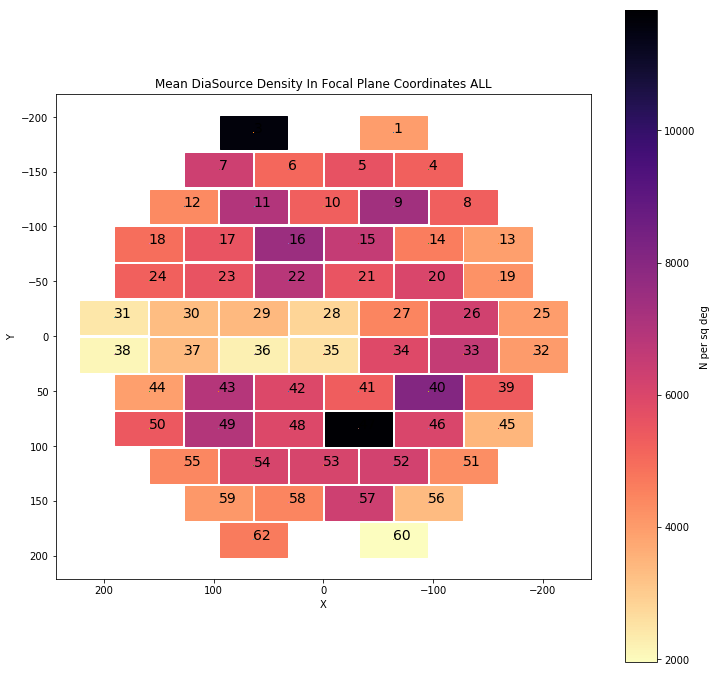

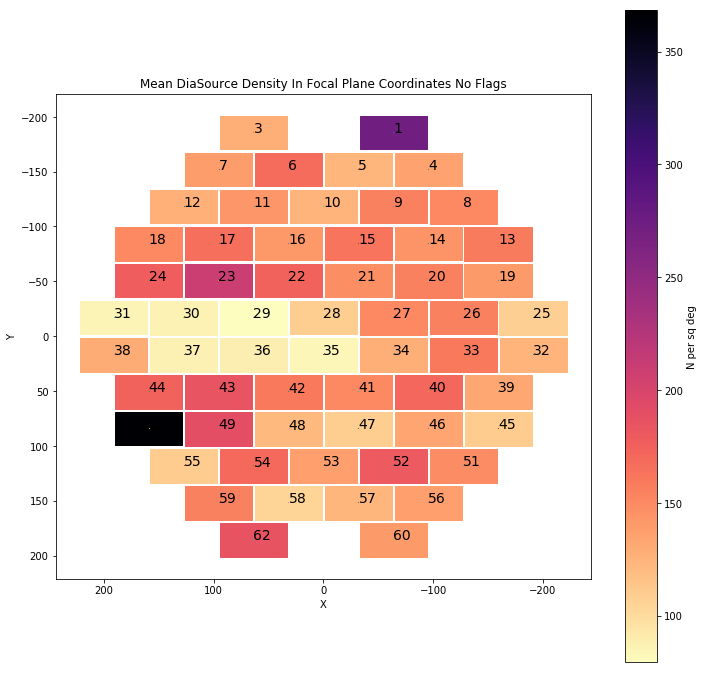

In [15]:
import matplotlib.patches as patches
import matplotlib as mpl
cmap = mpl.cm.magma_r

for grp, title in [(vgrp, "ALL"), (vgrpClean, "No Flags")]:
    yy = grp.visit.count().values/NVisits/APPROX_CCD_AREA
    norm = mpl.colors.Normalize(vmin= np.min(yy), vmax=np.max(yy))


    fig1 = plt.figure(figsize=(12,12))
    ax1 = fig1.add_subplot(111, aspect='equal')
    for index, row in corners.iterrows():
        ax1.add_patch(
        patches.Rectangle((row[7], row[6]), - row.height, -row.width, fill=True,
                          color=cmap(norm(grp.get_group('%02d'%row[1]).x.count()/NVisits/APPROX_CCD_AREA))))
        ax1.text(row[7]-row.height/2, row[6]-row.width/2, '%d'%(row[1]), fontsize=14)
        plt.plot(row[7]-row.height/2, row[6]-row.width/2, ',')
    ax1.set_title('Mean DiaSource Density In Focal Plane Coordinates %s' %(title))
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1 = plt.gca()
    ax1.invert_yaxis()
    ax1.invert_xaxis()
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = plt.colorbar(sm)
    cb.set_label('N per sq deg', rotation=90)
    plt.show()

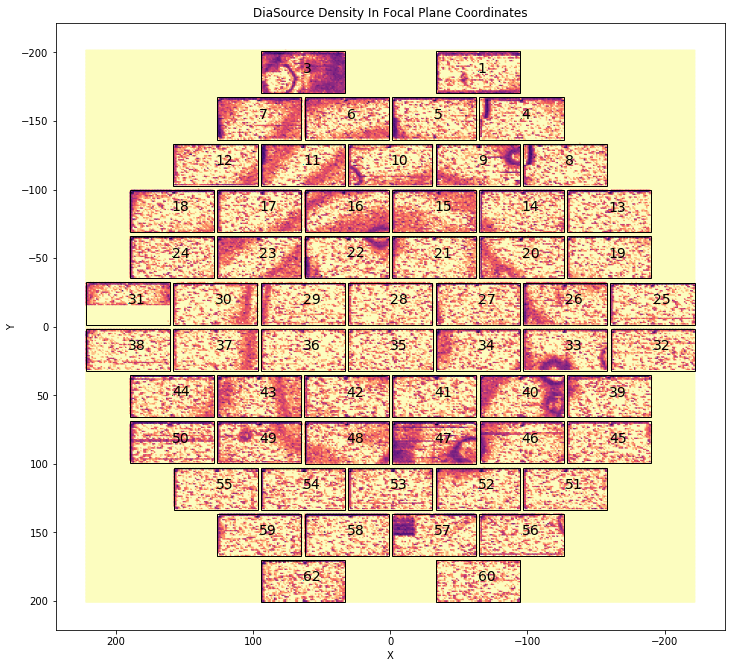

In [16]:
import matplotlib.patches as patches
fig1 = plt.figure(figsize=(12,12))
ax1 = fig1.add_subplot(111, aspect='equal')
for index, row in corners.iterrows():
    #print(row[2], row[3], -row.width, -row.height, row[2]-row.width/2, row[3]-row.height/2, '%d'%(row[1]))
    ax1.add_patch(
    patches.Rectangle((row[7], row[6]), - row.height, -row.width, fill=False))
    ax1.text(row[7]-row.height/2, row[6]-row.width/2, '%d'%(row[1]), fontsize=14)
    plt.plot(row[7]-row.height/2, row[6]-row.width/2, ',')


#plt.show()#cax = ax1.plot(ds['ra'][ds.visit == v], ds['decl'][ds.visit == v], '.', alpha=0.2)
ax1.hexbin(ds['yFP'], ds['xFP'], gridsize=(400,400), bins='log', cmap='magma_r')
ax1.set_title('DiaSource Density In Focal Plane Coordinates')
#ax1.colorbar()


ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1 = plt.gca()
ax1.invert_yaxis()
ax1.invert_xaxis()

plt.show()

We see a a few sources of detections here:
* Unmodeled background (illumination correction?)  (e.g. 15, 16, 20)
* Halos of bright stars (e.g. 47, 9, 8)
* Defects (e.g. 1, 57, 50)

In [17]:
pixelFlagNames = ['base_PixelFlags_flag',
 'base_PixelFlags_flag_offimage',
 'base_PixelFlags_flag_edge',
 'base_PixelFlags_flag_interpolated',
 'base_PixelFlags_flag_saturated',
 'base_PixelFlags_flag_cr',
 'base_PixelFlags_flag_bad',
 'base_PixelFlags_flag_suspect',
 'base_PixelFlags_flag_interpolatedCenter',
 'base_PixelFlags_flag_saturatedCenter',
 'base_PixelFlags_flag_crCenter',
 'base_PixelFlags_flag_suspectCenter',]
centroidFlagNames = ['slot_Centroid_flag',
 'slot_Centroid_pos_flag',
 'slot_Centroid_neg_flag',]
fluxFlagNames = ['slot_ApFlux_flag',
 'slot_ApFlux_flag_apertureTruncated',
 'slot_PsfFlux_flag',
 'slot_PsfFlux_flag_noGoodPixels',
 'slot_PsfFlux_flag_edge',
 'ip_diffim_forced_PsfFlux_flag',
 'ip_diffim_forced_PsfFlux_flag_noGoodPixels',
 'ip_diffim_forced_PsfFlux_flag_edge',]
shapeFlagNames =  ['slot_Shape_flag',
 'slot_Shape_flag_unweightedBad',
 'slot_Shape_flag_unweighted',
 'slot_Shape_flag_shift',
 'slot_Shape_flag_maxIter',
 'slot_Shape_flag_psf']

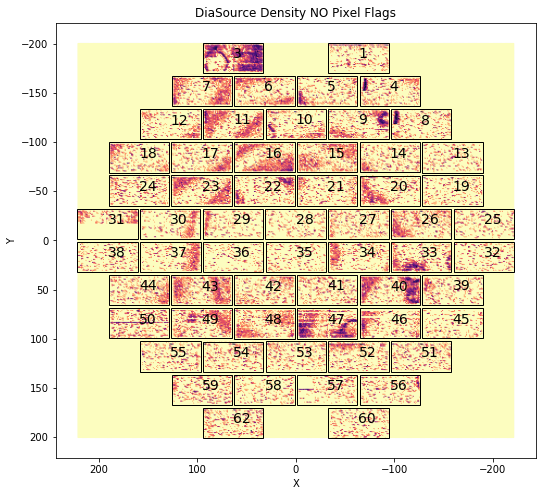

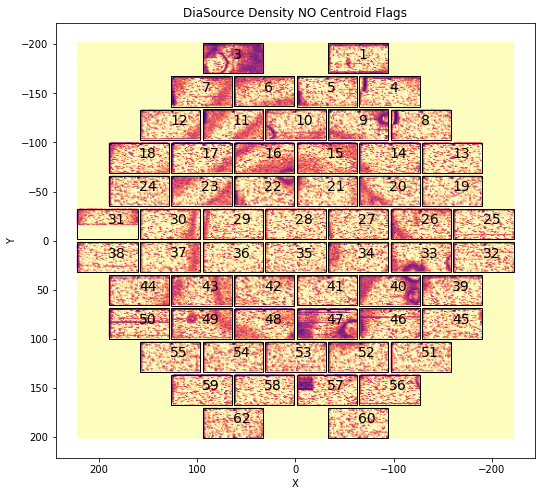

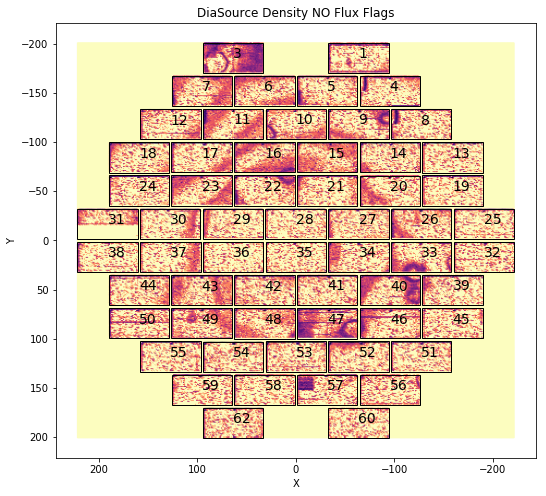

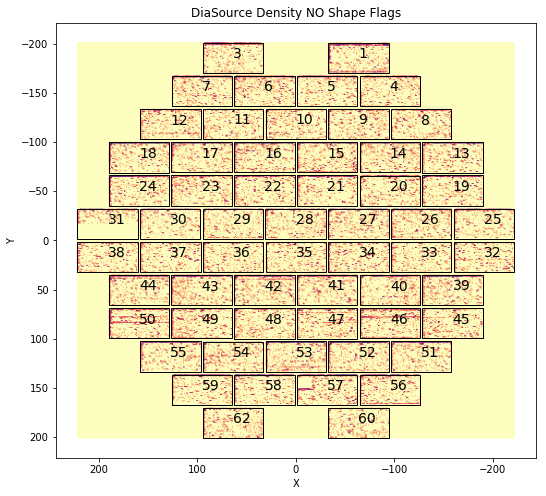

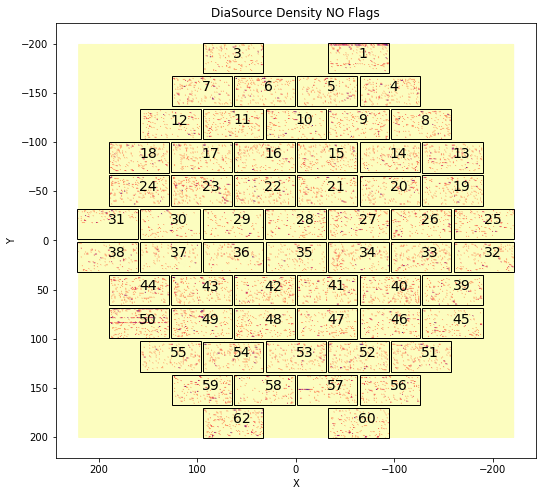

In [18]:

for i, (flagNames, title) in enumerate(zip([pixelFlagNames, centroidFlagNames, fluxFlagNames, shapeFlagNames, flag_names],
                                  ["Pixel Flags", "Centroid Flags", "Flux Flags", "Shape Flags", "Flags"])):
    idx = flagDF[flagNames].sum(axis = 1) == 0 
    fig1 = plt.figure(figsize=(12, 8))
    ax1 = fig1.add_subplot(111, aspect='equal')
    for index, row in corners.iterrows():
        ax1.add_patch( patches.Rectangle((row[7], row[6]), - row.height, -row.width, fill=False))
        ax1.text(row[7]-row.height/2, row[6]-row.width/2, '%d'%(row[1]), fontsize=14)
    ax1.hexbin(ds.yFP[idx], ds.xFP[idx], gridsize=(400,400), bins='log', cmap='magma_r')
    ax1.set_title('DiaSource Density NO %s' % title)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1 = plt.gca()
    ax1.invert_yaxis()
    ax1.invert_xaxis()

    plt.show()
    

Even the false positives with no flags set are preferentially on some parts of some chips. The defect masks should be expanded to include these areas: ccds 1, 50, 57.

Let's look at the specific pixel flags:

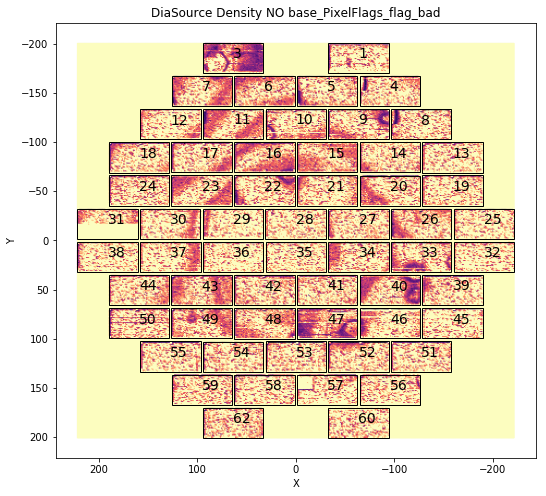

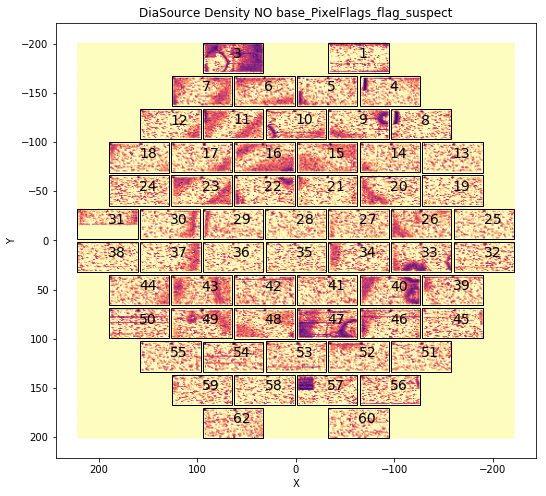

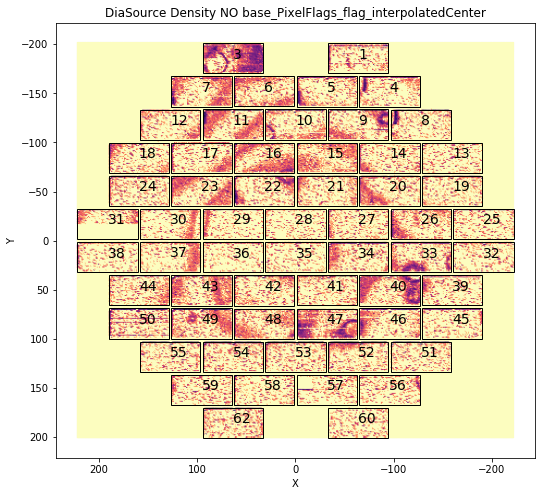

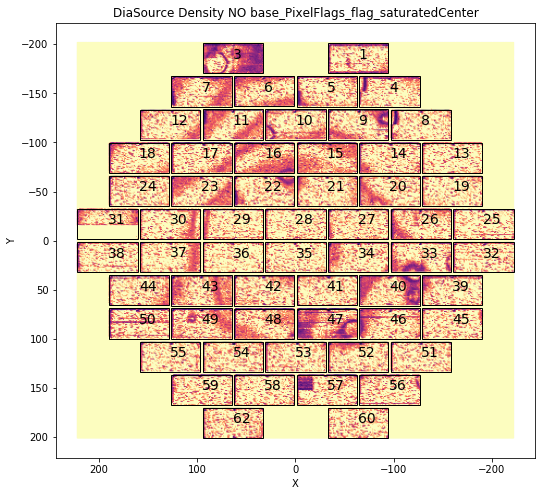

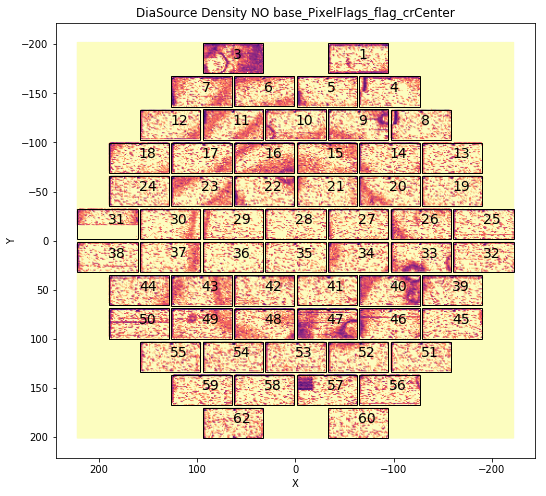

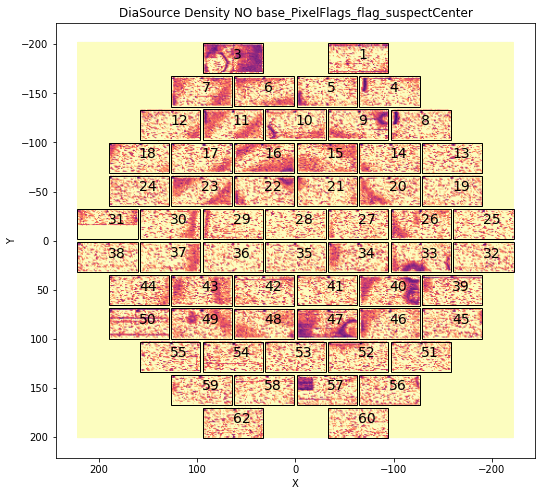

In [20]:
for i, flagName in enumerate(pixelFlagNames[-6:]):
    idx = ~flagDF[flagName]
    fig1 = plt.figure(figsize=(12, 8))
    ax1 = fig1.add_subplot(111, aspect='equal')
    for index, row in corners.iterrows():
        ax1.add_patch( patches.Rectangle((row[7], row[6]), - row.height, -row.width, fill=False))
        ax1.text(row[7]-row.height/2, row[6]-row.width/2, '%d'%(row[1]), fontsize=14)
    ax1.hexbin(ds.yFP[idx], ds.xFP[idx], gridsize=(400,400), bins='log', cmap='magma_r')
    ax1.set_title('DiaSource Density NO %s' % flagName)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1 = plt.gca()
    ax1.invert_yaxis()
    ax1.invert_xaxis()

    plt.show()

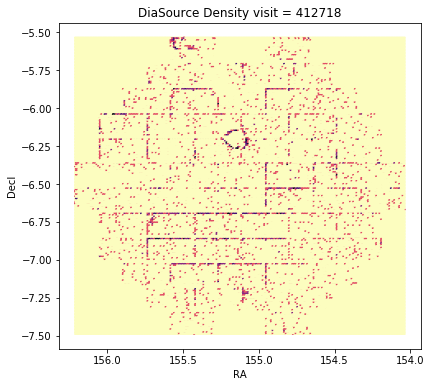

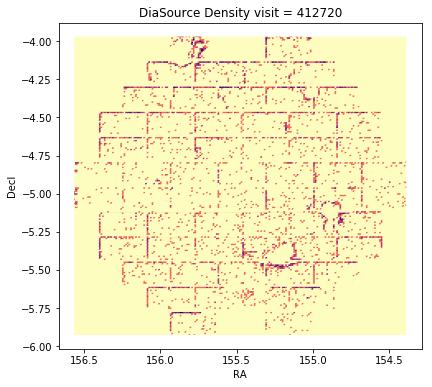

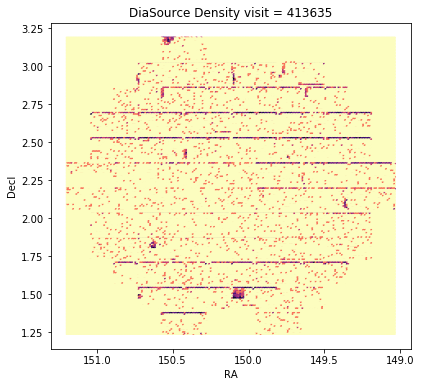

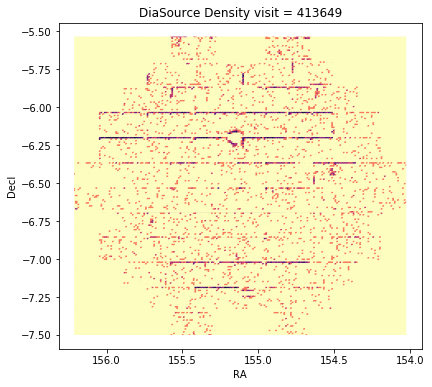

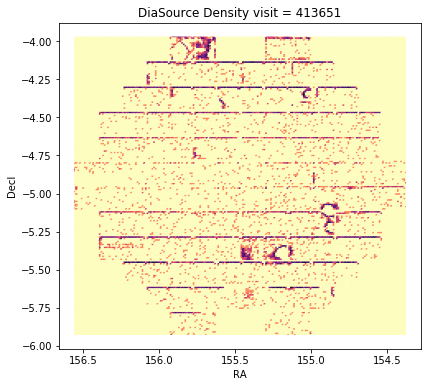

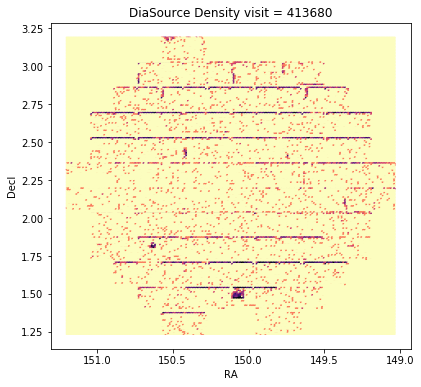

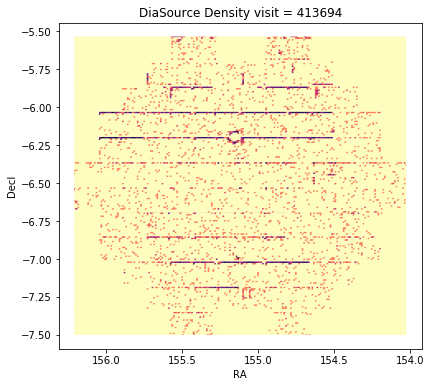

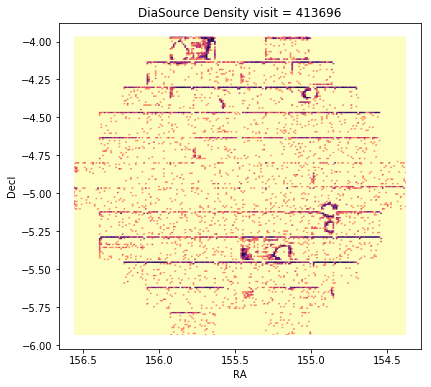

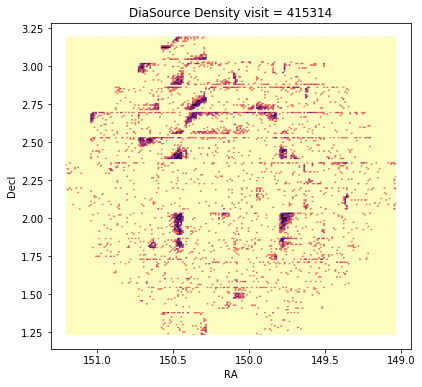

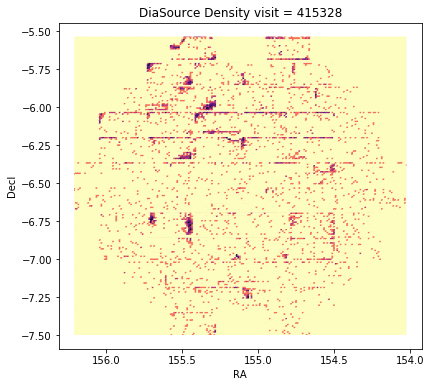

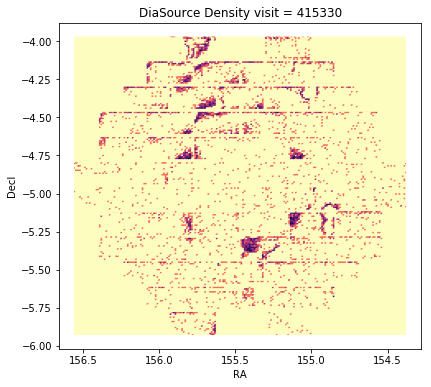

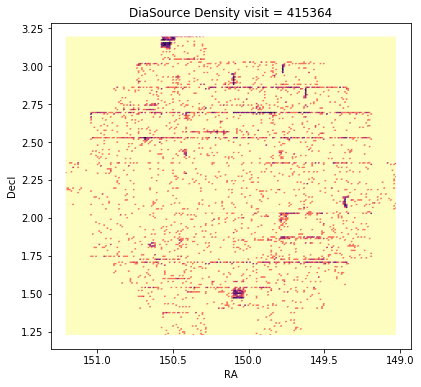

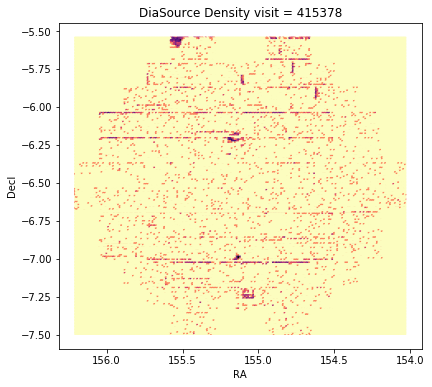

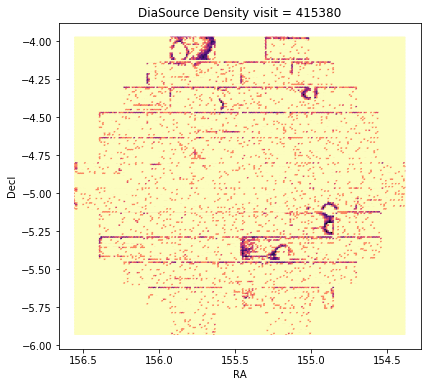

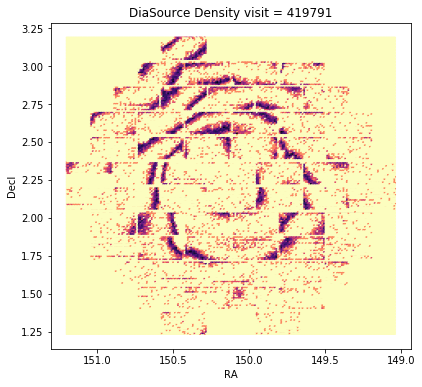

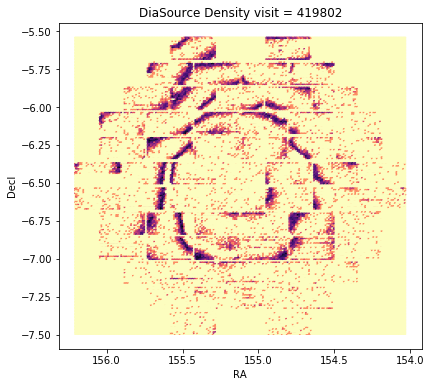

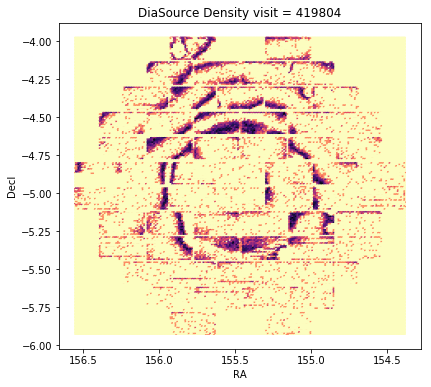

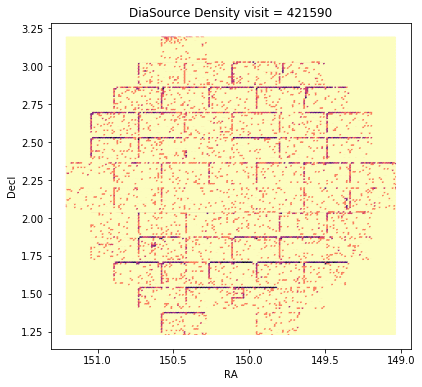

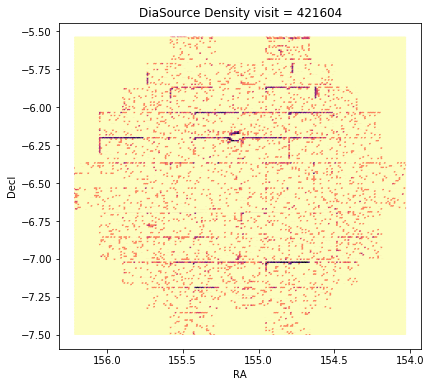

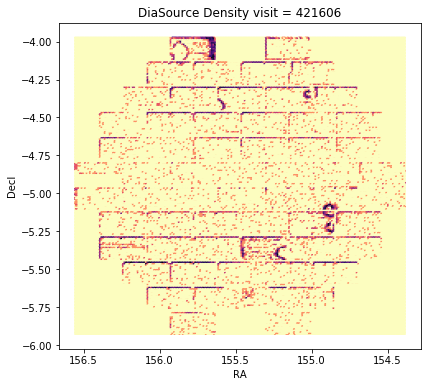

In [19]:
# DiaSources per visit:

for v in np.unique(ds['visit'].values)[-20:]:
    idx = ds.visit == v
    fig1 = plt.figure(figsize=(8, 6))
    ax1 = fig1.add_subplot(111, aspect='equal')
    ax1.hexbin(ds.ra[idx], ds.decl[idx], gridsize=(200,200), bins='log', cmap='magma_r')
    ax1.set_title('DiaSource Density visit = %s' % v)
    ax1.set_xlabel('RA')
    ax1.set_ylabel('Decl')
    ax1 = plt.gca()
    ax1.invert_xaxis()
    plt.show()

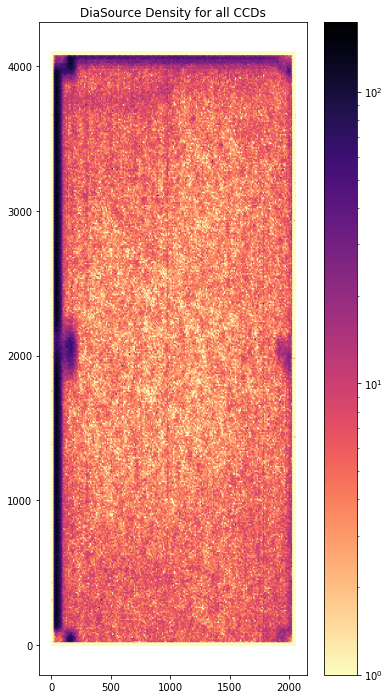

In [23]:
plt.figure(figsize=(6, 12))
plt.hexbin(ds.x, ds.y, gridsize=(200,400), bins='log', extent= [0,2048,0,4096], cmap='magma_r')
plt.title('DiaSource Density for all CCDs')
plt.colorbar()

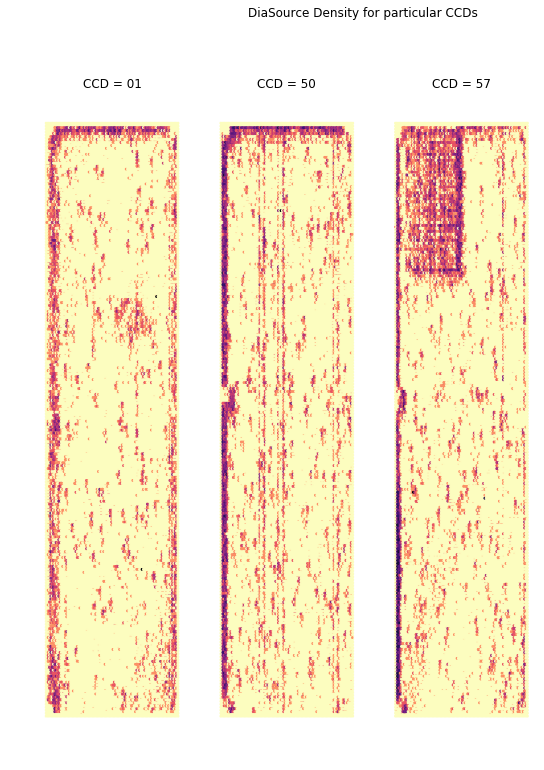

In [24]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle('DiaSource Density for particular CCDs')
for i, title in enumerate(['01', '50', '57']):
    ax = fig.add_subplot(1,4,i+1)
    idx = flagDF[flagNames].sum(axis = 1) == 0 
    ax.hexbin(ds.x[ds.ccd==title], ds.y[ds.ccd==title], gridsize=(100,200), bins='log',
              extent= [0,2048,0,4096], cmap='magma_r',  vmin=1, vmax=20)
    ax.set_title('CCD = %s' %title)
    plt.axis('off')

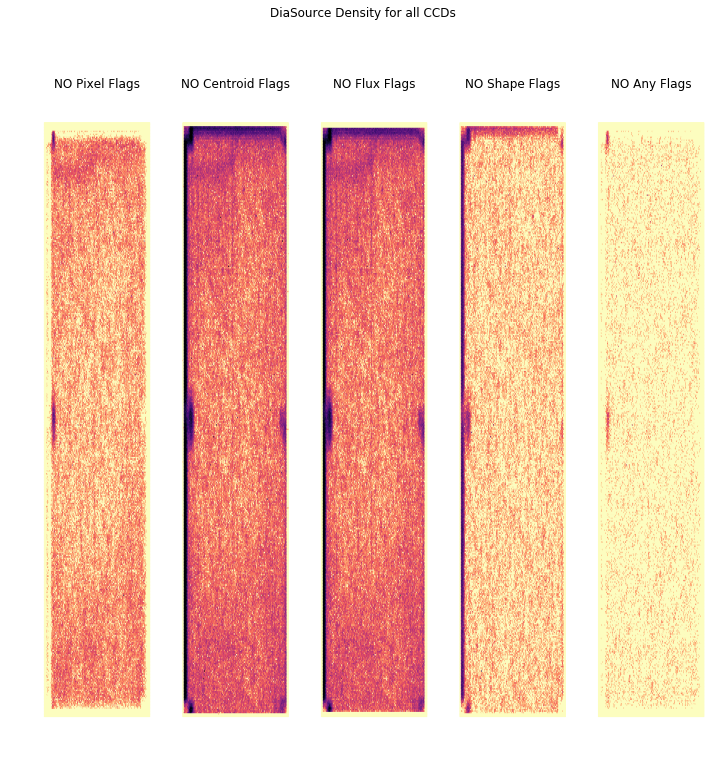

In [25]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle('DiaSource Density for all CCDs')
for i, (flagNames, title) in enumerate(zip([pixelFlagNames, centroidFlagNames, fluxFlagNames, shapeFlagNames, flag_names],
                                  ["Pixel Flags", "Centroid Flags", "Flux Flags", "Shape Flags", "Any Flags"])):
    ax = fig.add_subplot(1,5,i+1)
    idx = flagDF[flagNames].sum(axis = 1) == 0 
    ax.hexbin(ds.x[idx], ds.y[idx], gridsize=(200,400), bins='log',
              extent= [0,2048,0,4096], cmap='magma_r',  vmin=1, vmax=100)
    ax.set_title('NO %s' %title)
    plt.axis('off')
    #ax.colorbar()
    #plt.show()

In [26]:
ds['date_time'] = pd.to_datetime(ds.midPointTai, unit='D', origin=pd.Timestamp('1858-11-17'))
ds['date'] = ds['date_time'].dt.date
night_count = ds.groupby(('date', 'visit')).count()

/software/lsstsw/stack_20190330/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  This is separate from the ipykernel package so we can avoid doing imports until


# DiaSources per night

Nights with bad seeing are better. 

In [27]:
visits_per_night = night_count.groupby('date').count()
dia_per_night = night_count.groupby('date').sum()
pervisit_per_night = night_count.groupby('date').mean()
pervisit_per_night_std = night_count.groupby('date').std()

In [28]:
per_night = pd.merge(visits_per_night['x'], dia_per_night['x'], right_index=True, left_index=True)

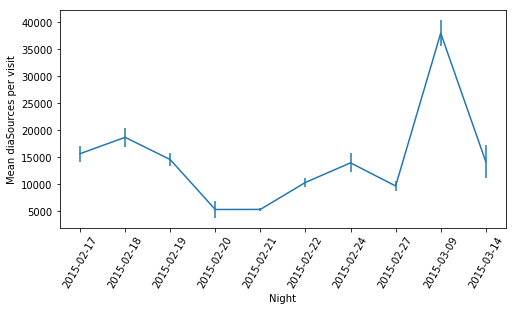

/software/lsstsw/stack_20190330/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(0, 16)

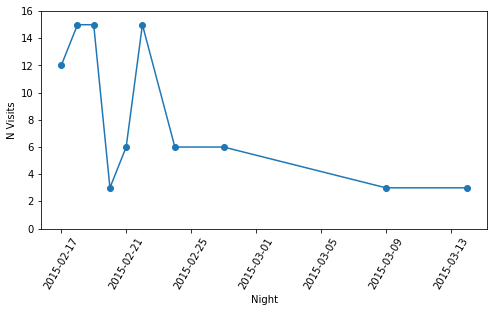

In [29]:
plt.figure(figsize=(8,4))
plt.errorbar(pervisit_per_night.index.values.astype('str'), pervisit_per_night['x'],
             yerr=pervisit_per_night_std['x']/np.sqrt(visits_per_night['x']))
#plt.xticks(pervisit_per_night.index.values.astype('str'))
_ = plt.xticks(rotation=60)
plt.xlabel('Night')
plt.ylabel('Mean diaSources per visit')
plt.show()
plt.figure(figsize=(8,4))
plt.plot(visits_per_night.index, visits_per_night['x'], 'o-')
_ = plt.xticks(rotation=60)
plt.xlabel('Night')
plt.ylabel('N Visits')
plt.ylim(0, np.max(visits_per_night['x'].values + 1))

In [30]:
# Previously read in v14 visits and seeing in FWHM Sigma
v14 = [(292405, 1.712740008064935) ,(289931, 3.0430986115576233) ,(289913, 2.067496141177234) ,(292413, 1.5718529700322488) ,(289893, 2.3721382301526526) ,(289892, 2.644930044874188) ,(289912, 2.043730430802592) ,(289871, 1.7801929506368983) ,(289870, 1.8201492804285682) ,(289851, 2.1273337251510633) ,(289828, 1.9688729689640228) ,(289850, 1.9490723971692596) ,(292404, 1.6632903034402353) ,(289782, 2.2838127394433685) ,(289820, 1.8773363535879868) ,(289907, 2.4112553058347586) ,(289818, 2.195999934285762) ,(289865, 1.7814106701367562) ,(289696, 1.929456954897101) ,(289783, 2.3108571978099235) ,(289823, 1.9027446016343372) ,(289655, 1.993046015765025) ,(289697, 2.1736108365192006) ,(289777, 2.679820977153997) ,(289613, 1.9409752456206506) ,(289656, 1.99062268324224) ,(289691, 2.1216564130666753) ,(289572, 2.2908393125610296) ,(289614, 1.9240402522381974) ,(289650, 2.0368131062106385) ,(289573, 2.2149216779581824) ,(289608, 2.3739804808781093) ,(289492, 1.8304209641689568) ,(289567, 2.4792999597111676) ,(289493, 1.7326605148457326) ,(289449, 1.5241523730254056) ,(289486, 2.1420008429835526) ,(289450, 1.5080960880744874) ,(289408, 1.8762782995861045) ,(289444, 1.6974806298434537) ,(289409, 1.7199381709404191) ,(289367, 2.3892629570160486) ,(289403, 2.1238109305816035) ,(289368, 2.4342739977145103) ,(289283, 2.75297361376061) ,(289362, 2.85673393682) ,(289284, 2.7242265550718217) ,(289278, 2.5968634902663714) ,(289242, 2.2553720651813123) ,(289243, 2.320754853029758) ,(289201, 3.166206352459513) ,(289237, 2.507224183745118) ,(289202, 3.2508057770451506) ,(289196, 2.8429249504352576) ,(289160, 2.9397518064584403) ,(289155, 3.2396259839682746) ,(289161, 2.9457573968632955) ,(289055, 2.780460120728085) ,(289050, 2.621900789404813) ,(289056, 2.602933074540136) ,(289015, 1.677039789571686) ,(289010, 1.629203896106453) ,(289016, 1.678422517344908) ,(288975, 1.6206524413721008) ,(288976, 1.5928920313234247) ,(288970, 1.6383891417767402) ,(288935, 2.0147346981780245) ,(288934, 2.0845881064614176) ,(288929, 2.1558456578610254)] 

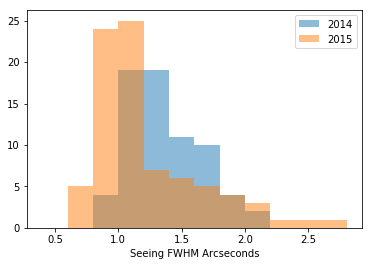

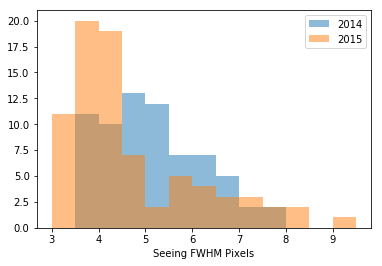

In [31]:
plt.hist(np.array(v14).T[1].astype(np.float)*2.355*0.263, alpha=0.5, label='2014', bins=np.arange(0.4,3,0.2))
plt.hist(fwhm.sigmaPix.values*2.355*0.263, alpha=0.5, label='2015', bins=np.arange(0.4,3,0.2))
plt.xlabel('Seeing FWHM Arcseconds')
plt.legend()
plt.show()
plt.hist(np.array(v14).T[1].astype(np.float)*2.355, alpha=0.5, label='2014', bins=np.arange(3,10,0.5))
plt.hist(fwhm.sigmaPix.values*2.355, alpha=0.5, label='2015', bins=np.arange(3,10,0.5))
plt.xlabel('Seeing FWHM Pixels')
plt.legend()
plt.show()

# Conclusions:
  
    1) Tape bumps visible, even when you filter out pixel flags. Should extend the defect masks. 
    2) Specific CCDs need extended masking as well. 
    3) The seeing in 2014 was systematically worse than 2015. This means that the "goodSeeing" templates are not "goodSeeing" in the context of 2015.
    4) DiaSource detections range from  65000 per sq deg and 450 per sq deg. The 10k is usually because of backgrounds that produce large swaths of "detections." 
   